In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date='2017-08-01'
end_date='2017-08-07'

def calc_temps(start_date,end_date):
    
    return (session.query(func.min(Measurement.tobs), 
                          func.round(
                          func.avg(Measurement.tobs)), 
                          func.max(Measurement.tobs))
                   .filter(Measurement.date >= start_date)
                   .filter(Measurement.date <= end_date)
                   .all())

trip_temperatures=calc_temps(start_date,end_date)
#print(trip_temp)

trip_temperatures_df=pd.DataFrame({'Start Date': start_date,
                           'End Date': end_date,
                           'Min Temp': [trip_temp[0][0]],
                           'Avg Temp': [trip_temp[0][1]],
                           'Max Temp': [trip_temp[0][2]]
                          })
trip_temperatures_df.set_index(['Start Date','End Date'],inplace=True)
trip_temperatures_df

,,Min Temp,Avg Temp,Max Temp
Start Date,End Date,,,
2017-08-01,2017-08-07,72.0,79.0,83.0


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [15]:
trip_avg = [int(result[1]) for result in trip_temp[::]]
trip_avg

[79]

In [17]:
tmax_tmin=(session.query(func.max(Measurement.tobs) - func.min(Measurement.tobs))
                  .filter(Measurement.date >= start_date)
                  .filter(Measurement.date <= end_date)
                  .all())
    
peak_to_peak=list(np.ravel(tmax_tmin))
peak_to_peak

[11.0]

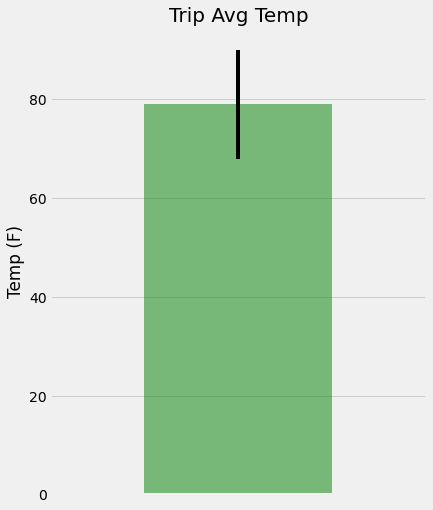

In [27]:
trip_df = pd.DataFrame(trip_temperatures, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='green')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])

plt.show()

### Daily Rainfall Average

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_precipitation_by_station=(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),
                                Station.latitude,Station.longitude,Station.elevation)
                         .filter(Measurement.date >= start_date)
                         .filter(Measurement.date <= end_date)
                         .filter(Measurement.station == Station.station)
                         .group_by(Measurement.station)
                         .order_by(func.sum(Measurement.prcp)
                         .desc())
                         .all())
total_precipitation_by_station=pd.DataFrame(total_precipitation_by_station, columns=['Station', 'Name', 'Total Precip', 'Latitude', 'Longitude', 'Elevation'])
total_precipitation_by_station

,Station,Name,Total Precip,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates=['08-01','08-02','08-03','08-04','08-05',
            '08-06','08-07']

# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals=[]
    
def daily_normals(date):
    sel = [func.min(Measurement.tobs), 
           func.round(func.avg(Measurement.tobs),2), 
           func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

for i in trip_dates:
    normals.append(daily_normals(i)[0])

normals


[(67.0, 75.54, 83.0),
 (68.0, 75.6, 84.0),
 (70.0, 76.61, 85.0),
 (69.0, 76.71, 84.0),
 (69.0, 76.15, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.16, 83.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_daily_normals_df=pd.DataFrame(normals,columns=['Min Temp','Avg Temp','Max Temp'],
                                   index=trip_dates)

trip_daily_normals_df.index.name='date'
trip_daily_normals_df

,Min Temp,Avg Temp,Max Temp
date,,,
08-01,67.0,75.54,83.0
08-02,68.0,75.60,84.0
08-03,70.0,76.61,85.0
08-04,69.0,76.71,84.0
08-05,69.0,76.15,82.0
08-06,67.0,76.25,83.0
08-07,71.0,77.16,83.0


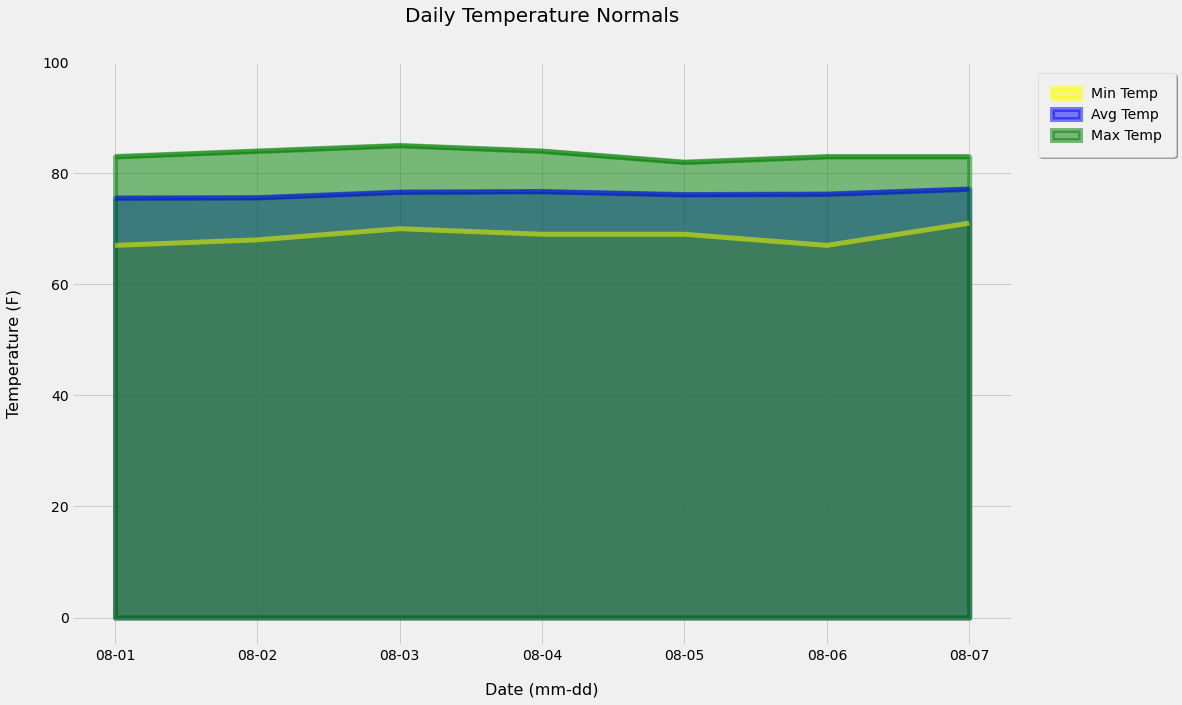

In [40]:
# Plot the daily normals as an area plot with `stacked=False`

plt.rcParams['figure.figsize']=(15,10)
colors=['yellow','blue','green']
trip_daily_normals_df.plot.area(linewidth=5,stacked=False,rot=0,alpha=0.5,color=colors);

plt.ylim(-5,100)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.xlabel('Date (mm-dd)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Temperature Normals',fontsize=20,pad=40)
plt.gca().legend(loc='center left', bbox_to_anchor=(1.02, 0.91),shadow=True,borderpad=1);

## Close Session

In [41]:
session.close()